In [ ]:
# --- STEP 1: Import Libraries ---
import pandas as pd
import numpy as np
import re
import sqlite3
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords

# there are a few new ones you'll need to install, run this module first and pip install in terminal -Oliver
# !pip install wordcloud
# !pip install textblob
# !pip install nltk

In [ ]:

# --- STEP 2: Data Acquisition ---
# I added a fair few print outs here when I was working on this to keep track. We can remove for the final version if you prefer. -Oliver
data_file_path = os.path.join("resources", "spotify_millsongdata.csv")
df = pd.read_csv(data_file_path)

print("Data loaded successfully from:", data_file_path)
print("Columns in the CSV:", df.columns.tolist())

# Create a copy so that we do not modify the base CSV data
df_processed = df.copy()

# Back up the original CSV data
original_csv_backup = os.path.join("resources", "original_spotify_millsongdata.csv")
df.to_csv(original_csv_backup, index=False)
print("Original CSV data backed up as:", original_csv_backup)

# Connect to a SQLite database (database stored in the resources folder)
db_path = os.path.join("resources", "music_lyrics.db")
conn = sqlite3.connect(db_path)
df_processed.to_sql("raw_lyrics", conn, if_exists="replace", index=False)
print("Raw data stored in SQL database at:", db_path)

Data loaded successfully from: resources\spotify_millsongdata.csv
Columns in the CSV: ['artist', 'song', 'link', 'text']
Original CSV data backed up as: resources\original_spotify_millsongdata.csv
Raw data stored in SQL database at: resources\music_lyrics.db


In [6]:
# --- STEP 3: Text Preprocessing ---
stop_words = set(stopwords.words("english"))

def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(r"[^\w\s]", "", text)
    # Tokenize by splitting on whitespace
    tokens = text.split()
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Return the cleaned text
    return " ".join(filtered_tokens)

# Use the 'text' column from your dataset
if "text" not in df_processed.columns:
    raise KeyError("The dataset does not have a column named 'text'. Please update the code with the correct column.")

df_processed["clean_text"] = df_processed["text"].apply(lambda x: clean_text(str(x)))
print("Text cleaning complete.")


Text cleaning complete.


In [8]:
# --- STEP 4: Sentiment Analysis using TextBlob ---
# Define function to compute sentiment scores
def get_sentiment(text):
    # TextBlob's polarity ranges from -1 (negative) to 1 (positive)
    return TextBlob(text).sentiment.polarity

df_processed["sentiment_score"] = df_processed["clean_text"].apply(get_sentiment)
print("Sentiment scores calculated using TextBlob.")

# Save the processed DataFrame as a new CSV so the base CSV remains unchanged.
processed_csv_path = os.path.join("resources", "processed_spotify_millsongdata.csv")
df_processed.to_csv(processed_csv_path, index=False)
print("Processed data saved to:", processed_csv_path)

# Store the processed data into SQL for further querying.
df_processed.to_sql("processed_lyrics", conn, if_exists="replace", index=False)
print("Processed sentiment data stored in SQL.")


Sentiment scores calculated using TextBlob.
Processed data saved to: resources\processed_spotify_millsongdata.csv
Processed sentiment data stored in SQL.


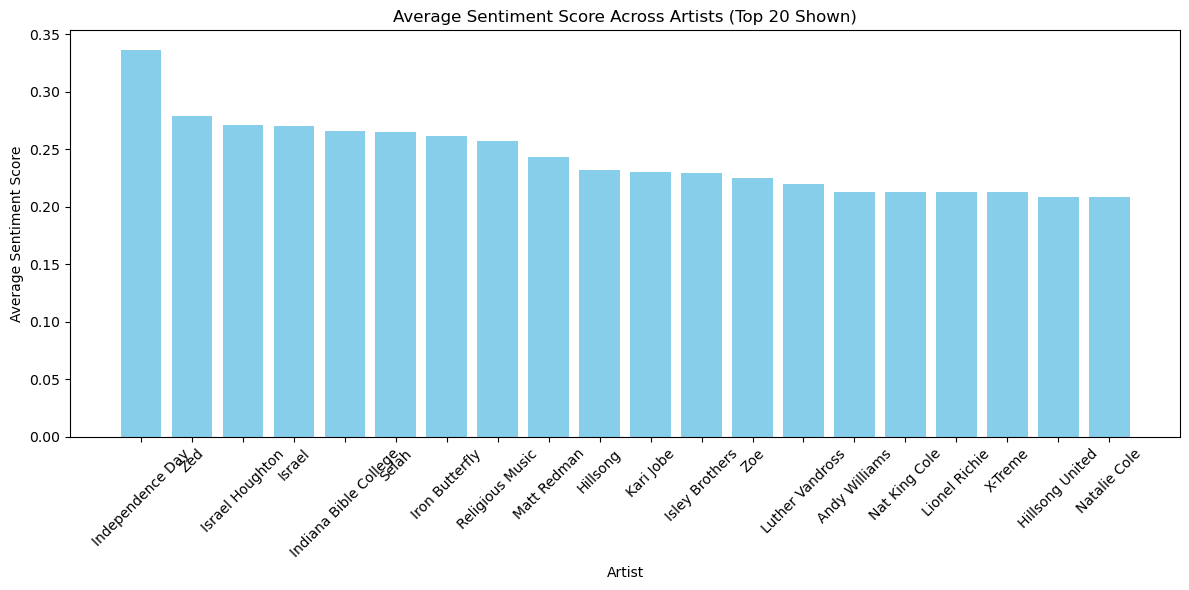

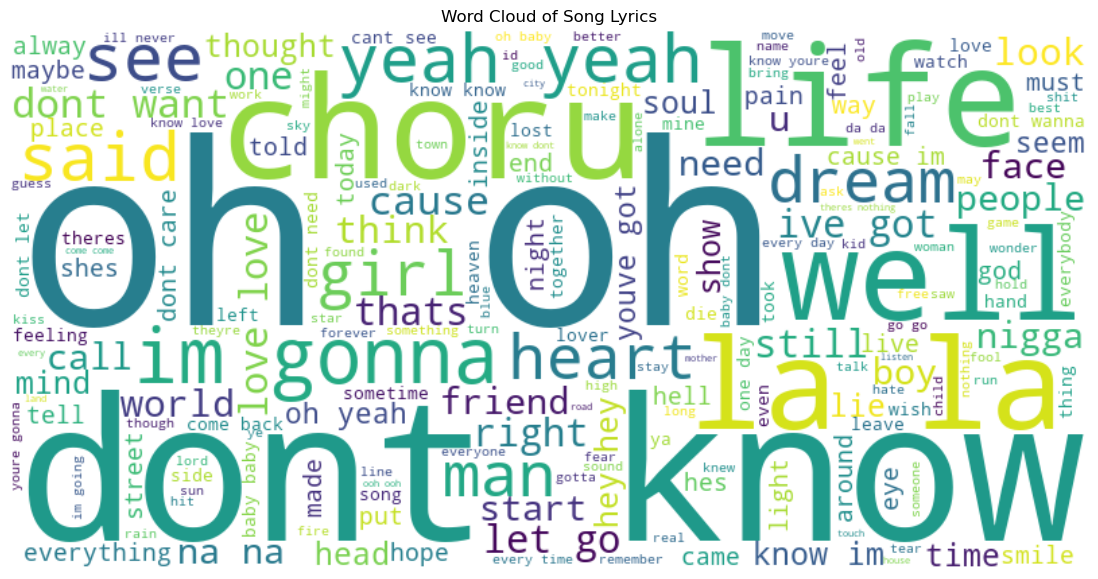

In [ ]:
# --- STEP 5: Sentiment Visualization ---
# Plot distribution of sentiment scores
# for our visualizations we need to decide what we are trying to pull from this set
if "genre" in df_processed.columns:
    grouping_column = "genre"
    title_text = "Average Sentiment Score Across Music Genres"
elif "artist" in df_processed.columns:
    grouping_column = "artist"
    title_text = "Average Sentiment Score Across Artists (Top 20 Shown)"
else:
    # If neither column exists, just create a histogram of sentiments.
    grouping_column = None

if grouping_column:
    group_sentiment = df_processed.groupby(grouping_column)["sentiment_score"].mean().reset_index()
    
    # Optionally, if grouping by artist and there are too many, you can take the top 20 for visualization.
    if grouping_column == "artist" and len(group_sentiment) > 20:
        # Sort artists by sentiment score and take top 20 (or based on count, you can pick the most frequent)
        group_sentiment = group_sentiment.sort_values(by="sentiment_score", ascending=False).head(20)
    
    plt.figure(figsize=(12, 6))
    plt.bar(group_sentiment[grouping_column], group_sentiment["sentiment_score"], color="skyblue")
    plt.xlabel(grouping_column.capitalize())
    plt.ylabel("Average Sentiment Score")
    plt.title(title_text)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    # Just plot a histogram of sentiment scores if no grouping is available.
    plt.figure(figsize=(10, 6))
    plt.hist(df_processed["sentiment_score"], bins=20, color="skyblue", edgecolor="black")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")
    plt.title("Distribution of Sentiment Scores")
    plt.tight_layout()
    plt.show()

# Generate word cloud of lyrics
# I kept this in for fun since I got it working, but totally useless in the context of this project, maybe we use it as a presentation visual -Oliver
all_text = " ".join(df_processed["clean_text"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Song Lyrics")
wordcloud_output_path = os.path.join("resources", "wordcloud.png")
plt.savefig(wordcloud_output_path)
plt.show()



In [ ]:
# --- STEP 6: Sentiment Prediction Using Machine Learning ---
# Create a binary sentiment label (1 = positive/neutral, 0 = negative)
df_processed["sentiment_label"] = df_processed["sentiment_score"].apply(lambda x: 1 if x >= 0 else 0)

# Extract text features using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(df_processed["clean_text"])
y = df_processed["sentiment_label"]

# Split data into training/testing sets
# I used 80% training and 20% testing, but feel free to adjust this as needed. Ensures we do not overfit the model. -Oliver
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression classifier
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# the above is tested but I wonder if we can up the accuracy by using a different model. 89% is not bad though. 


Accuracy on test set: 0.8902862098872506
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.68      0.77      3169
           1       0.89      0.97      0.93      8361

    accuracy                           0.89     11530
   macro avg       0.89      0.82      0.85     11530
weighted avg       0.89      0.89      0.88     11530

Confusion Matrix:
 [[2140 1029]
 [ 236 8125]]


In [11]:

# --- STEP 7: Close Database Connection ---
conn.close()
print("SQL connection closed.")

SQL connection closed.
